https://github.com/rasbt/machine-learning-book

In [11]:
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Figure from Machine Learning with PyTorch and Scikit-Learn


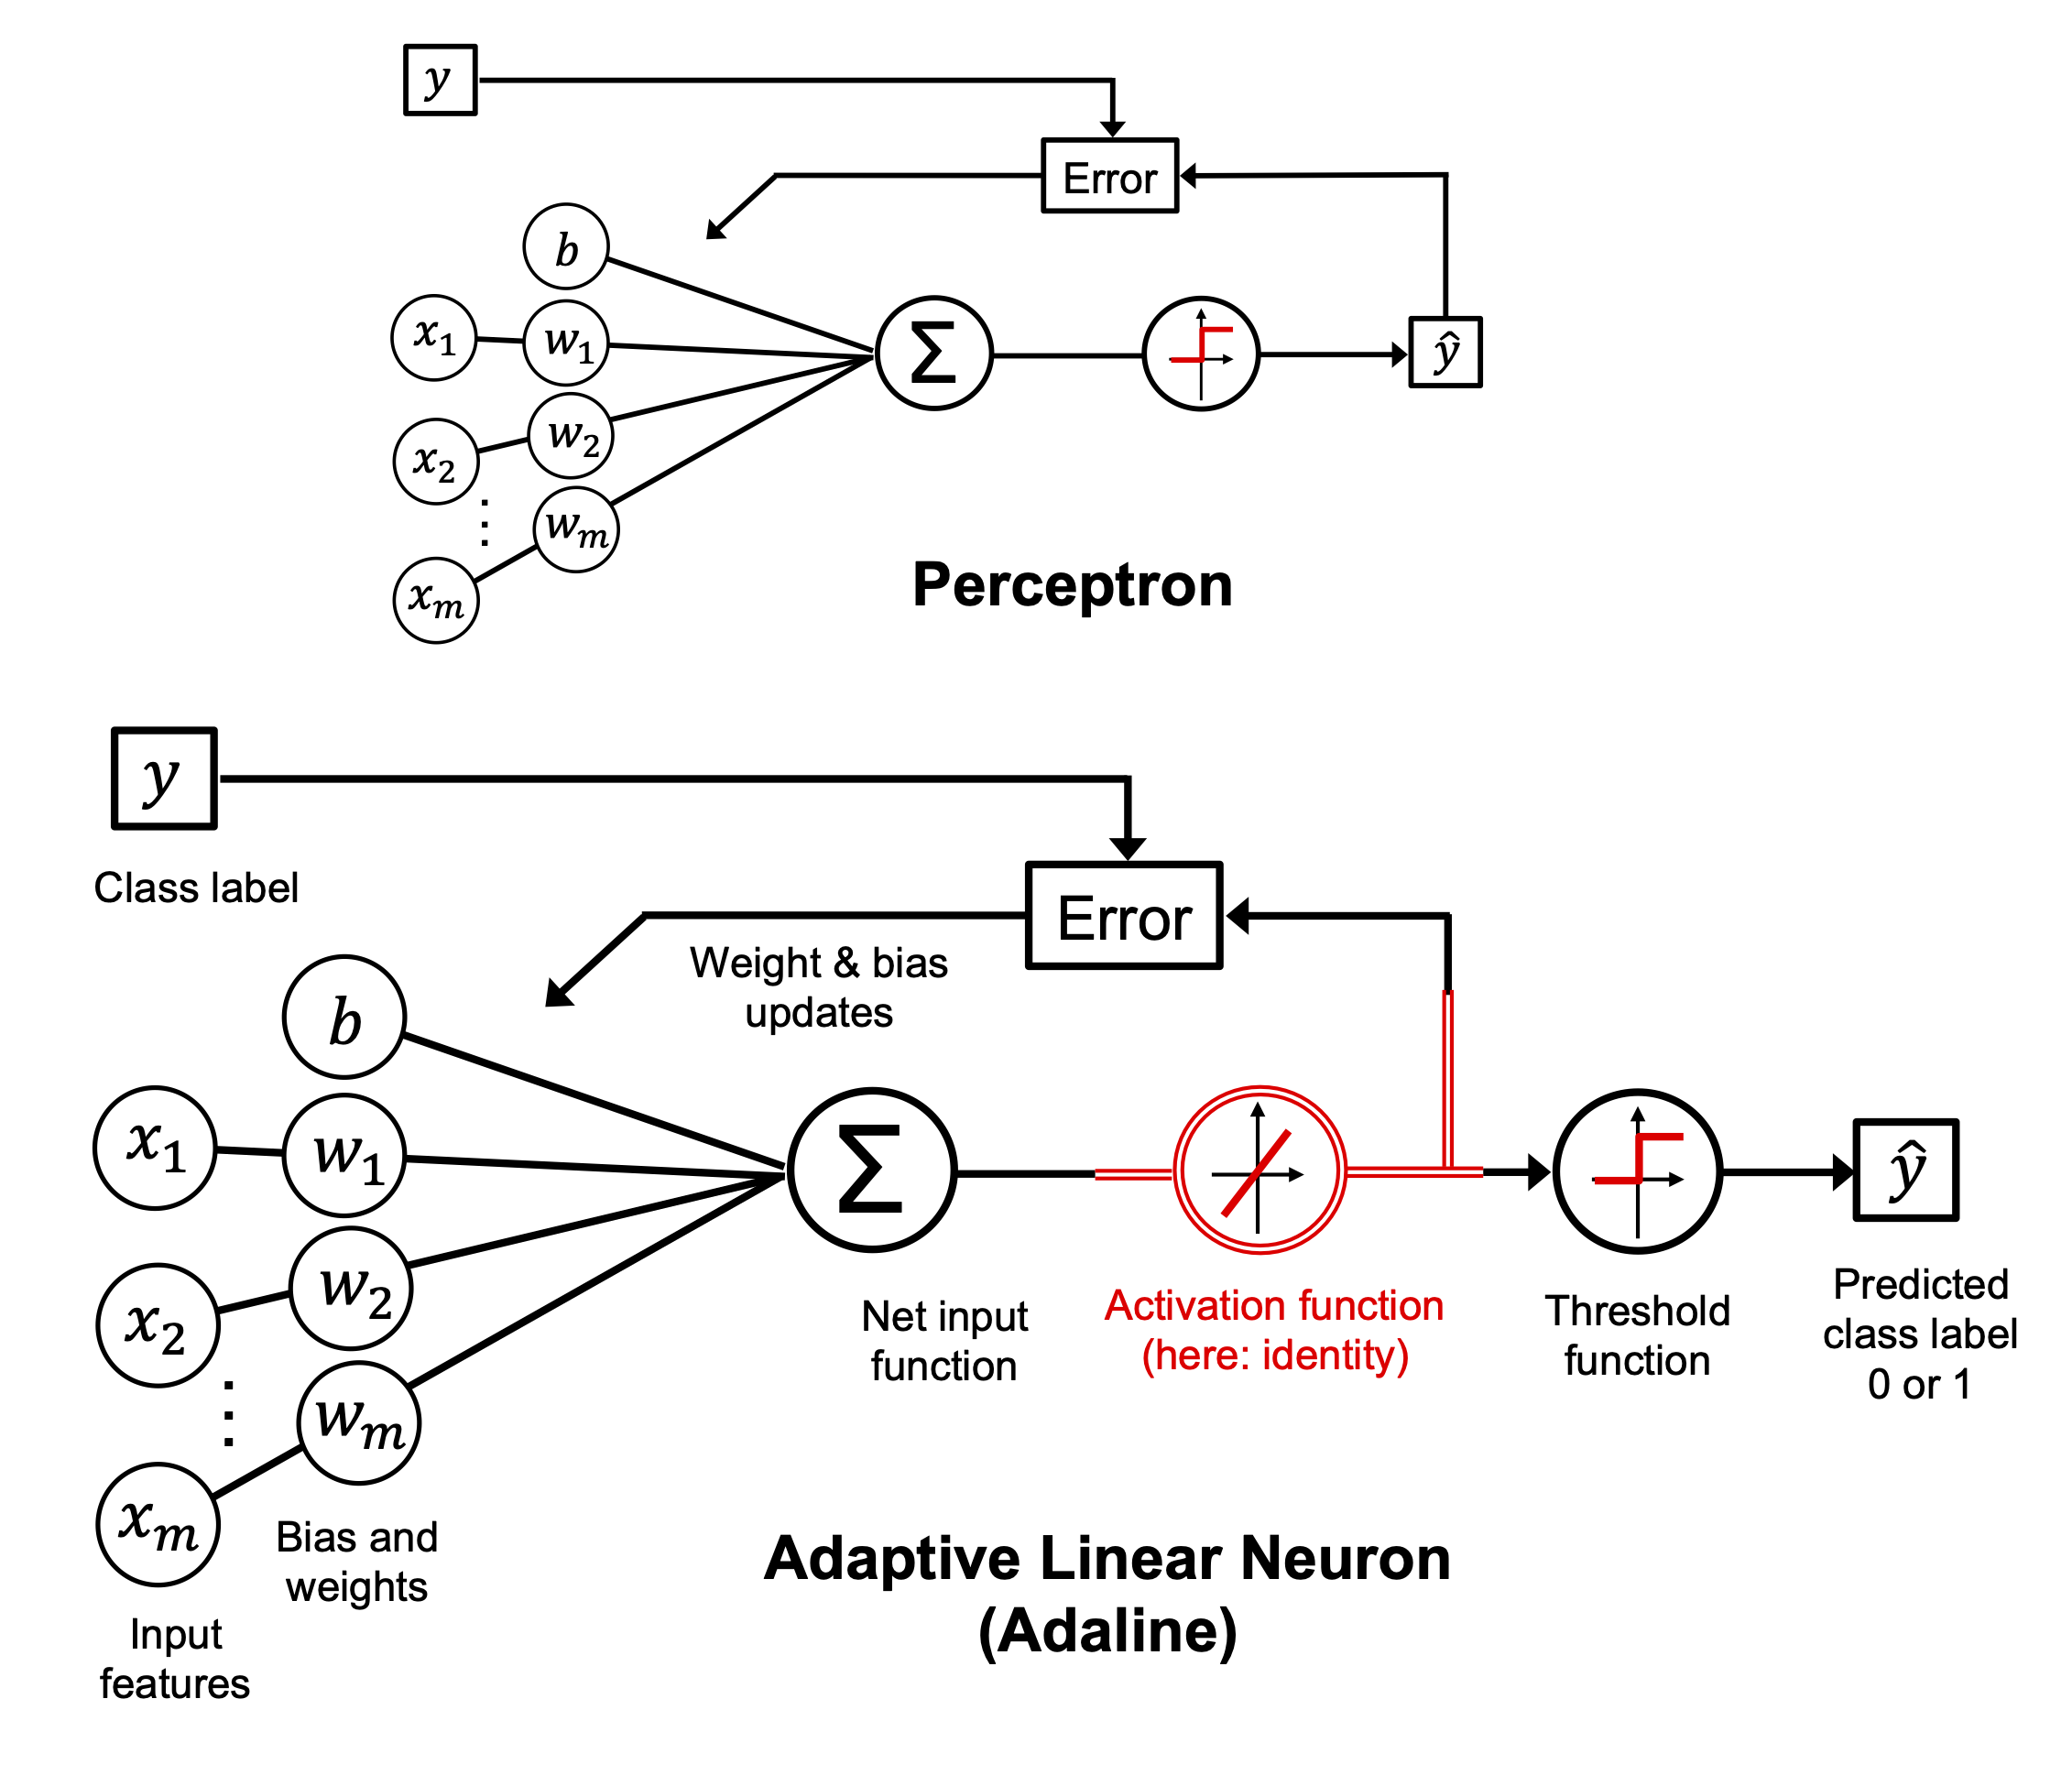

In [12]:
print("Figure from Machine Learning with PyTorch and Scikit-Learn")
Image(filename='./imgs/02_09.png', width=200) 

# Perceptron

In [13]:
# Perceptron classifier
class Perceptron:
    def __init__(self,
                 eta : float = 0.01,
                 n_iter : int = 50,
                 rnd_state: int = 1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = rnd_state
    

    def fit(self,
            X : 'array [N_example, n_feat]',
            y : 'array [n_feat]') -> 'Perceptron':
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc = 0.0, scale = 0.01, size = X.shape[1])
        self.b_ = np.float_(0.)
        self.errors_ = []
        
        for _ in range(self.n_iter):
            errors = 0
            
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_ += update * xi
                self.b_ += update
                errors += int(update != 0.0)
            
            self.errors_.append(errors)
        return self
    
    def net_input(self, X : 'array [N_example, n_feat]') -> float:
        return np.dot(X, self.w_) + self.b_
    
    def predict(self, X) -> int:
        return np.where(self.net_input(X) >= 0.0, 1, 0)
        

In [14]:
source = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
df = pd.read_csv(source, header = None, encoding = 'utf-8')

In [15]:
df

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


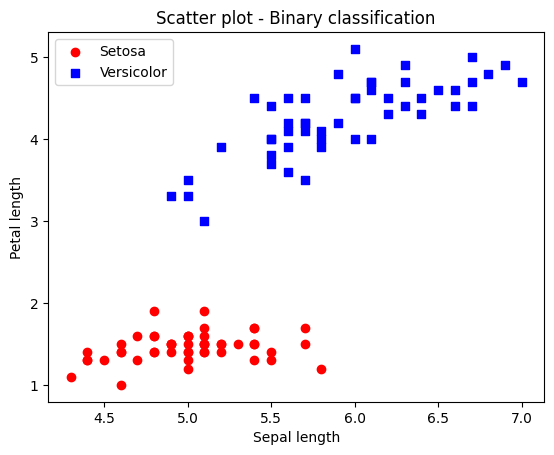

In [16]:
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', 0, 1)
X = df.iloc[0:100, [0,2]].values

plt.scatter(X[:50,0], X[:50,1], color = 'red', marker = 'o', label = 'Setosa')
plt.scatter(X[50:100,0], X[50:100,1], color = 'blue', marker = 's', label = 'Versicolor')
plt.title('Scatter plot - Binary classification')
plt.xlabel('Sepal length')
plt.ylabel('Petal length')
plt.legend(loc ='upper left')
plt.show()

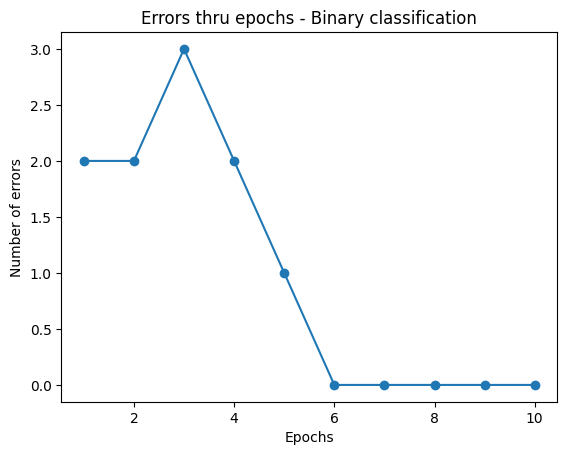

In [17]:
ppn = Perceptron(eta = 0.1, n_iter = 10)
ppn.fit(X, y)
plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker = 'o')
plt.title('Errors thru epochs - Binary classification')
plt.xlabel('Epochs')
plt.ylabel('Number of errors')
plt.show()

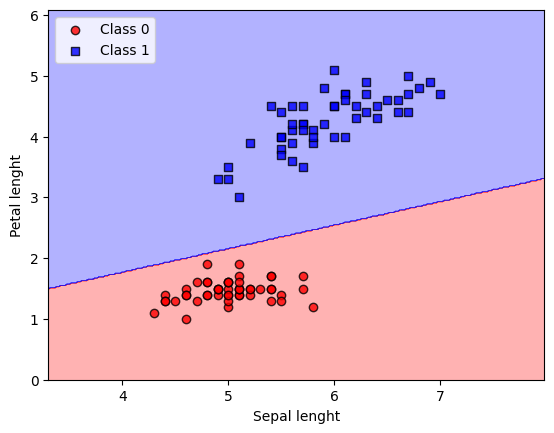

In [18]:
# Decision boundaries

from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution = 0.02):
    # marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'green', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # decision surface
    x1_min, x1_max = X[:,0].min() - 1, X[:,0].max() + 1
    x2_min, x2_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    
    plt.contourf(xx1, xx2, lab, alpha = 0.3, cmap = cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x = X[y == cl, 0],
                    y = X[y == cl, 1],
                    alpha = 0.8,
                    c = colors[idx],
                    marker = markers[idx],
                    label = f'Class {cl}',
                    edgecolors = 'black')
        
plot_decision_regions(X, y, classifier = ppn)
plt.xlabel('Sepal lenght')
plt.ylabel('Petal lenght')
plt.legend(loc='upper left')
plt.show()

# Adaline w/ Gradient Descent (GD) and Stochastic Gradient Descent (SGD)

In [19]:
# Perceptron w/ Gradient Descent + ID function as activation +  MSE as loss function
class AdalineGD:
    def __init__(self,
                 eta : float = 0.01,
                 n_iter : int = 50,
                 rnd_state : int = 1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = rnd_state
        
    def fit(self,
            X : 'array [N_example, n_feat]',
            y : 'array [n_feat]') -> 'Perceptron':
        rgen = np.random.RandomState(self.random_state)
        
        self.w_ = rgen.normal(loc = 0.0, scale = 0.01, size = X.shape[1])
        self.weight_alt = self.w_.copy()
        
        self.b_ = np.float_(0.0)
        self.losses_ = []
        
        for i in range (self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            
            for wj in range(self.w_.shape[0]):
                self.weight_alt[wj] += self.eta * 2.0 *(X[:, wj]*errors).mean()
            
            loss = (errors**2).mean()
            self.losses_.append(loss)

        return self
        
    def net_input(self, X) -> float:
        return np.dot(X, self.w_) + self.b_
    
    def activation(self, X) -> 'array':
        return X
    
    def predict(self, X) -> 'array':
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

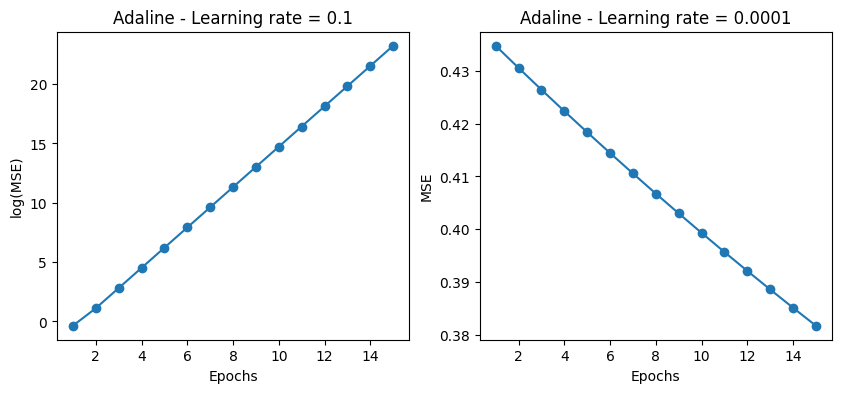

In [20]:
# Learning rate tunning effects -> Too high / Too low
fig, axs = plt.subplots(1, 2, figsize = (10,4))

ada1 = AdalineGD(n_iter = 15, eta = 0.1).fit(X, y)
ax = axs[0]
ax.plot(range(1, len(ada1.losses_) + 1),
        np.log10(ada1.losses_), marker = 'o')

ax.set_xlabel("Epochs")
ax.set_ylabel("log(MSE)")
ax.set_title("Adaline - Learning rate = 0.1")

ada2 = AdalineGD(n_iter = 15, eta = 0.0001).fit(X, y)
ax = axs[1]
ax.plot(range(1, len(ada2.losses_) + 1),
        ada2.losses_, marker = 'o')

ax.set_xlabel("Epochs")
ax.set_ylabel("MSE")
ax.set_title("Adaline - Learning rate = 0.0001")

plt.show()

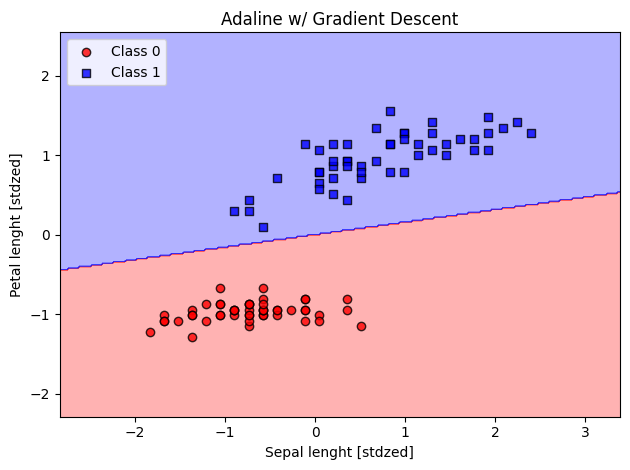

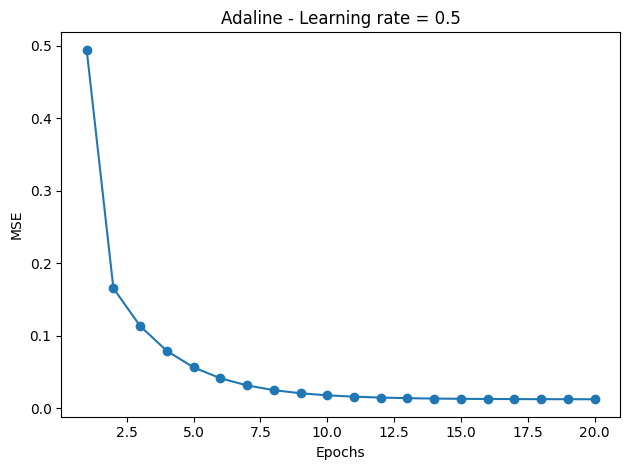

In [21]:
# Standardization effect

X_std = np.copy(X)
for idx in range(X.shape[1]):
    X_std[:, idx] = (X_std[:, idx] - X_std[:, idx].mean()) / (X_std[:, idx]).std()
    
ada = AdalineGD(n_iter = 20, eta = 0.5)
ada.fit(X_std, y)
plot_decision_regions(X_std, y, classifier = ada)

plt.title("Adaline w/ Gradient Descent")
plt.xlabel('Sepal lenght [stdzed]')
plt.ylabel('Petal lenght [stdzed]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
plt.plot(range(1, len(ada.losses_) + 1),
        ada.losses_, marker = 'o')

plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Adaline - Learning rate = 0.5")
plt.tight_layout()
plt.show()

In [22]:
# ADA w/ Stocastic Gradient Descent (SGD)

class ADA_SGD:
    
    def __init__(self,
                 eta : float = 0.01,
                 n_iter : int = 10,
                 shuffle : bool = True,
                 rnd_state : int = 1):
        self.eta = eta
        self.n_iter = n_iter
        self.shuffle = shuffle
        self.random_state = rnd_state
        
    def fit(self, X, y) -> 'self':
        self._initialize_weights(X.shape[1])
        self.losses_ = []
        
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            
            losses = []
            for xi, target in zip(X, y):
                losses.append(self._update_weights(xi, target))
            
            avg_loss = np.mean(losses)
            self.losses_.append(avg_loss)
            
        return self
    
    def partial_fit(self, X, y):
        if not self.w_initialized_:
            self._initialize_weights(X.shape[1])
        
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
            
    def _shuffle(self, X, y):
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc = 0.0, scale = 0.01, size = m)
        self.b_ = np.float_(0.0)
        self.w_initialized_ = True
        
    def _update_weights(self, xi, target):
        output = self.activation(self.net_input(xi))
        error = (target - output)
        
        self.w_ += self.eta * 2.0 * xi * error
        self.b_ += self.eta * 2.0 * error
        
        loss = error**2
        return loss
    
    def net_input(self, X):
        return np.dot(X, self.w_) + self.b_
    
    def activation(self, X):
        return X
    
    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

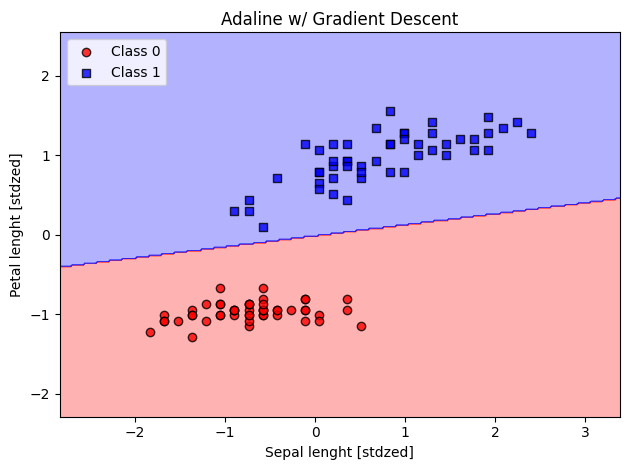

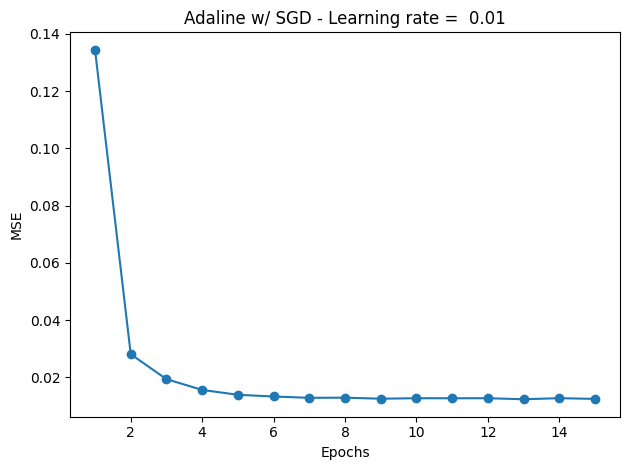

In [23]:
ada_sgd = ADA_SGD(n_iter = 15, eta = 0.01)
ada_sgd.fit(X_std, y)
plot_decision_regions(X_std, y, classifier = ada_sgd)

plt.title("Adaline w/ Gradient Descent")
plt.xlabel('Sepal lenght [stdzed]')
plt.ylabel('Petal lenght [stdzed]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
plt.plot(range(1, len(ada_sgd.losses_) + 1),
        ada_sgd.losses_, marker = 'o')

plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title(f"Adaline w/ SGD - Learning rate = {ada_sgd.eta : .2f}")
plt.tight_layout()
plt.show()